In [1]:
import tsai
from tsai.all import *
print('tsai       :', tsai.__version__)
print('fastai     :', fastai.__version__)
print('fastcore   :', fastcore.__version__)
print('torch      :', torch.__version__)

C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.JPIJNSWNNAN3CE6LLI5FWSPHUT2VXMTH.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\eason\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


tsai       : 0.2.15
fastai     : 2.2.5
fastcore   : 1.3.19
torch      : 1.7.1+cu101


# 0. load data

In [2]:
input_fn = 'F:\\Github\\kaggle drought\\data_ndarray.npz'

In [3]:
data = np.load(open(input_fn, 'rb'))

In [4]:
X_train = data['X_train']

In [5]:
X_train.shape

(118024, 90, 18)

In [6]:
print(np.mean(X_train.flatten()))

1.1619668e-07


In [7]:
print(np.std(X_train.flatten()))

1.0000005


In [8]:
X_valid = data['X_valid']

In [9]:
X_test = data['X_test']

In [10]:
y_train = data['y_train']
y_train = np.array([int(i) for i in y_train])

In [11]:
y_valid = data['y_valid']
y_valid = np.array([int(i) for i in y_valid])

In [12]:
y_test = data['y_test']
y_test = np.array([int(i) for i in y_test])

We need to exchange two axes：
* **number of samples**
* **number of features** (aka variables, dimensions, channels)
* **number of steps** (or length, time steps, sequence steps)

In [13]:
X_train = X_train.transpose(0, 2, 1)
X_train.shape

(118024, 18, 90)

In [14]:
X_valid = X_valid.transpose(0, 2, 1)
X_valid.shape

(20721, 18, 90)

In [15]:
X_test = X_test.transpose(0, 2, 1)
X_test.shape

(102430, 18, 90)

We already have the split:

In [16]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [17]:
X.shape

(138745, 18, 90)

In [18]:
y.shape

(138745,)

In [19]:
splits

((#118024) [0,1,2,3,4,5,6,7,8,9...],
 (#20721) [118024,118025,118026,118027,118028,118029,118030,118031,118032,118033...])

In [20]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits, inplace=True)
dsets

(#138745) [(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(2, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(0, dtype=torch.int32)),(TSTensor(vars:18, len:90), TensorCategory(1, dtype=torch.int32))...]

# 1. Model and Hyperparameter Tuning

In [21]:
import hyperopt
print(hyperopt.__version__)

0.2.5


In [22]:
from hyperopt import Trials, STATUS_OK, STATUS_FAIL, tpe, fmin, hp

In [23]:
search_space = {
    'batch_size': hp.choice('bs', [256, 512, 1024]),
    'time_steps': hp.choice('ts', [30, 60, 90]),  # lookback window size
    "lr": hp.choice('lr', [0.1, 0.01, 0.001, 0.0001]),
    "epochs": hp.choice('epochs', [10, 50, 100]),  # we would also use early stopping
    "patience": hp.choice('patience', [5, 10]),  # early stopping patience
    "optimizer": hp.choice('optimizer', [Adam, SGD, RMSProp]),  # https://docs.fast.ai/optimizer
    # model parameters
    "nf": hp.choice('nf', [16, 32, 64])
}

In [24]:
search_space

{'batch_size': <hyperopt.pyll.base.Apply at 0x2556d24af88>,
 'time_steps': <hyperopt.pyll.base.Apply at 0x2556d248608>,
 'lr': <hyperopt.pyll.base.Apply at 0x2556d248d48>,
 'epochs': <hyperopt.pyll.base.Apply at 0x2556d24c388>,
 'patience': <hyperopt.pyll.base.Apply at 0x2556d24c908>,
 'optimizer': <hyperopt.pyll.base.Apply at 0x2556d24cf08>,
 'nf': <hyperopt.pyll.base.Apply at 0x2556d246588>}

In [25]:
X.shape

(138745, 18, 90)

In [26]:
time_steps = 30

In [27]:
X[:, :, -time_steps:].shape

(138745, 18, 30)

In [28]:
X_test[:, :, -time_steps:].shape

(102430, 18, 30)

In [29]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])

In [30]:
import time
from fastai.callback.tracker import EarlyStoppingCallback

In [31]:
import gc

In [32]:
# clear memory 
gc.collect()

192

In [33]:
def create_model_hypopt(params):
    
    try:
        # clear memory 
        gc.collect()
        print("Trying params:",params)
        batch_size = params["batch_size"]
        time_steps = params["time_steps"]
    
        # Create data loader
        tfms  = [None, [Categorize()]]
        dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
        # set num_workers for memory bottleneck
        dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
        # Create model
        arch = InceptionTime
        k = {
            'nf': params['nf']
        }
        model = create_model(arch, dls=dls, **k)
        print(model.__class__.__name__)
    
        # Training the model
        learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
        start = time.time()
        learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                            cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
        learn.plot_metrics()
        elapsed = time.time() - start
    
        vals = learn.recorder.values[-1]
        # vals[0], vals[1], vals[2]
        # train loss, valid loss, accuracy
        val_loss = vals[1]
    
        # delete tmp variables
        del dls
        del model
        del learn
        return {'loss': val_loss, 'status': STATUS_OK} # if accuracy use '-' sign, model is optional
    except:
        return {'loss': None, 'status': STATUS_FAIL}

Search the parameters:

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 50, 'lr': 0.001, 'nf': 16, 'optimizer': <function Adam at 0x000002552D0DD438>, 'patience': 10, 'time_steps': 60}
InceptionTime                                                                                                          
  0%|                                                                           | 0/30 [00:27<?, ?trial/s, best loss=?]

epoch,train_loss,valid_loss,accuracy,time
0,1.178074,1.140991,0.631195,00:07
1,0.950266,0.944279,0.672024,00:05
2,0.849528,0.917582,0.680421,00:05
3,0.782459,0.950784,0.658993,00:05
4,0.719316,0.980929,0.640317,00:05
5,0.669103,1.036112,0.675643,00:05
6,0.629467,1.027279,0.620675,00:05
7,0.596514,1.311646,0.674388,00:05
8,0.561953,1.051757,0.671348,00:05
9,0.543780,1.362745,0.623232,00:05


No improvement since epoch 2: early stopping                                                                           
  0%|                                                                           | 0/30 [01:45<?, ?trial/s, best loss=?]

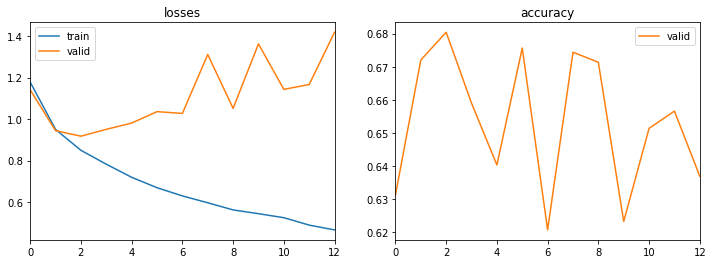

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 50, 'lr': 0.001, 'nf': 32, 'optimizer': <function SGD at 0x000002552D0DD0D8>, 'patience': 10, 'time_steps': 60}
InceptionTime                                                                                                          
  3%|█▋                                               | 1/30 [02:12<51:01, 105.56s/trial, best loss: 1.419044852256775]

epoch,train_loss,valid_loss,accuracy,time
0,1.929077,1.882905,0.105256,00:10
1,1.473183,1.418315,0.645336,00:09
2,1.206758,1.169984,0.662709,00:09
3,1.103248,1.087071,0.661696,00:09
4,1.035494,1.042653,0.657883,00:09
5,1.000465,1.006238,0.657208,00:09
6,0.963373,0.980571,0.657883,00:09
7,0.958511,0.965141,0.660200,00:09
8,0.925587,0.957010,0.661744,00:09
9,0.913680,0.938807,0.667294,00:10


No improvement since epoch 15: early stopping                                                                          
  3%|█▋                                               | 1/30 [06:34<51:01, 105.56s/trial, best loss: 1.419044852256775]

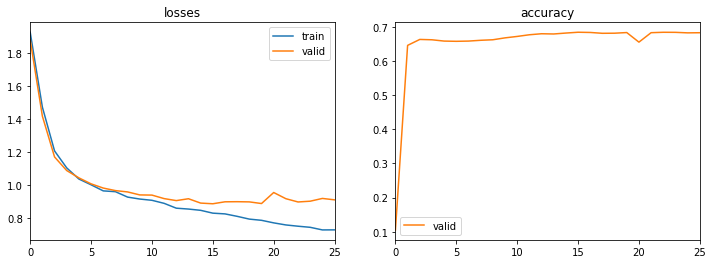

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 50, 'lr': 0.0001, 'nf': 32, 'optimizer': <function Adam at 0x000002552D0DD438>, 'patience': 10, 'time_steps': 90}
InceptionTime                                                                                                          
  7%|███                                           | 2/30 [07:01<1:14:56, 160.57s/trial, best loss: 0.9088351130485535]

epoch,train_loss,valid_loss,accuracy,time
0,1.632911,1.611416,0.459148,00:11
1,1.420698,1.368104,0.570291,00:10
2,1.207812,1.162912,0.632740,00:10
3,1.056523,1.012225,0.659669,00:10
4,0.947758,0.950854,0.670190,00:10
5,0.868228,0.909808,0.677187,00:10
6,0.805960,0.964509,0.677525,00:10
7,0.752799,0.829663,0.701124,00:10
8,0.708806,1.000385,0.675305,00:10
9,0.670122,0.957003,0.627383,00:10


No improvement since epoch 7: early stopping                                                                           
  7%|███                                           | 2/30 [10:08<1:14:56, 160.57s/trial, best loss: 0.9088351130485535]

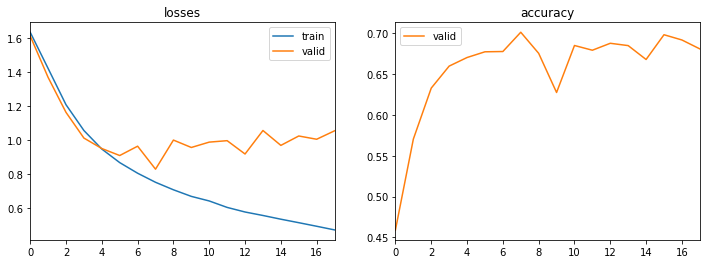

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 100, 'lr': 0.0001, 'nf': 16, 'optimizer': <function RMSProp at 0x000002552D0DD1F8>, 'patience': 10, 'time_steps': 30}
InceptionTime                                                                                                          
 10%|████▌                                         | 3/30 [10:39<1:19:31, 176.72s/trial, best loss: 0.9088351130485535]

epoch,train_loss,valid_loss,accuracy,time
0,1.541945,1.488810,0.572221,00:05
1,1.422396,1.385188,0.587037,00:04
2,1.323189,1.287630,0.610492,00:05
3,1.230007,1.206825,0.623715,00:04
4,1.148990,1.116430,0.646156,00:04
5,1.077081,1.062940,0.651368,00:05
6,1.024013,1.002688,0.664929,00:05
7,0.980071,0.994741,0.666956,00:05
8,0.954434,0.956736,0.674485,00:05
9,0.921158,0.971755,0.671251,00:05


No improvement since epoch 11: early stopping                                                                          
 10%|████▌                                         | 3/30 [12:30<1:19:31, 176.72s/trial, best loss: 0.9088351130485535]

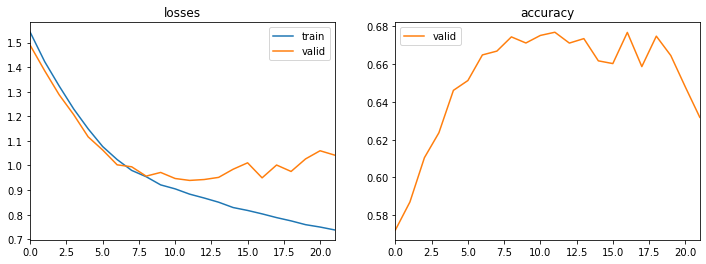

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'lr': 0.01, 'nf': 16, 'optimizer': <function RMSProp at 0x000002552D0DD1F8>, 'patience': 10, 'time_steps': 60}
InceptionTime                                                                                                          
 13%|██████▏                                       | 4/30 [13:00<1:12:02, 166.23s/trial, best loss: 0.9088351130485535]

epoch,train_loss,valid_loss,accuracy,time
0,0.899095,1.065047,0.615366,00:05
1,0.844300,1.322701,0.585059,00:05
2,0.746447,1.045957,0.661841,00:05
3,0.664156,1.172504,0.660393,00:05
4,0.590058,1.256576,0.660875,00:05
5,0.521561,1.485020,0.638290,00:05
6,0.454296,1.512149,0.628203,00:05
7,0.387510,1.711555,0.612519,00:05
8,0.339445,1.839103,0.611457,00:05
9,0.308936,1.888108,0.617876,00:05


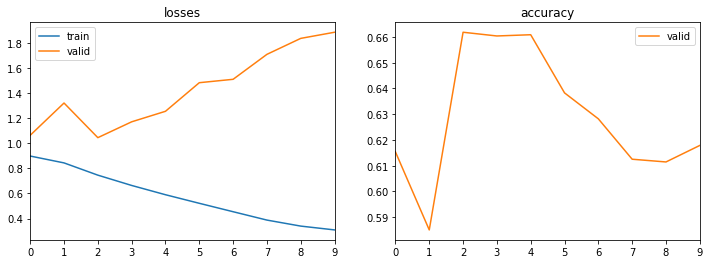

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 50, 'lr': 0.01, 'nf': 16, 'optimizer': <function RMSProp at 0x000002552D0DD1F8>, 'patience': 5, 'time_steps': 30}
InceptionTime                                                                                                          
 17%|████████                                        | 5/30 [14:27<59:23, 142.53s/trial, best loss: 0.9088351130485535]

epoch,train_loss,valid_loss,accuracy,time
0,0.916744,0.942856,0.679552,00:04
1,0.866901,1.064333,0.674147,00:04
2,0.839331,1.064815,0.661020,00:04
3,0.812480,1.151917,0.651030,00:04
4,0.792547,1.096114,0.622267,00:04
5,0.760233,1.097229,0.633222,00:04


No improvement since epoch 0: early stopping                                                                           
 17%|████████                                        | 5/30 [14:56<59:23, 142.53s/trial, best loss: 0.9088351130485535]

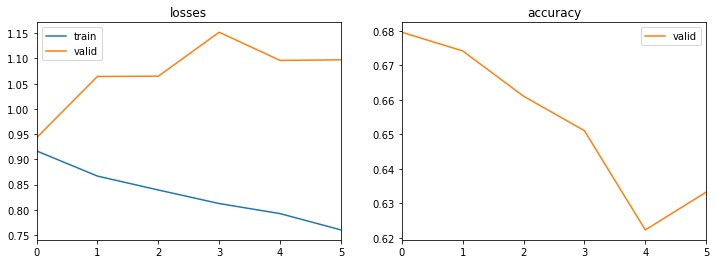

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'lr': 0.1, 'nf': 64, 'optimizer': <function SGD at 0x000002552D0DD0D8>, 'patience': 5, 'time_steps': 90}
InceptionTime                                                                                                          
 20%|█████████▌                                      | 6/30 [15:22<46:58, 117.45s/trial, best loss: 0.9088351130485535]

epoch,train_loss,valid_loss,accuracy,time
0,1.006099,1.008180,0.651996,00:22
1,0.934493,0.939659,0.666281,00:21
2,0.895107,0.897463,0.675691,00:21
3,0.866146,0.956611,0.647556,00:21
4,0.845439,0.850123,0.689783,00:21
5,0.819414,1.128003,0.612664,00:21
6,0.795560,0.857482,0.691135,00:22
7,0.761728,1.119110,0.665653,00:22
8,0.741844,1.066536,0.677718,00:22
9,0.720494,0.923322,0.672506,00:22


No improvement since epoch 4: early stopping                                                                           
 20%|█████████▌                                      | 6/30 [19:02<46:58, 117.45s/trial, best loss: 0.9088351130485535]

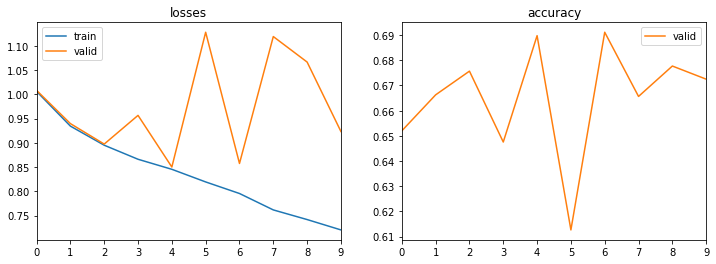

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 10, 'lr': 0.01, 'nf': 64, 'optimizer': <function Adam at 0x000002552D0DD438>, 'patience': 10, 'time_steps': 90}
InceptionTime                                                                                                          
 23%|███████████▏                                    | 7/30 [19:28<59:50, 156.13s/trial, best loss: 0.9088351130485535]

epoch,train_loss,valid_loss,accuracy,time
0,0.818145,0.816407,0.688625,00:25
1,0.708895,1.507289,0.679842,00:25
2,0.601151,1.297774,0.655132,00:25
3,0.528281,1.397112,0.611071,00:25
4,0.442224,1.496161,0.665364,00:25
5,0.367519,1.720261,0.629603,00:25
6,0.302348,1.609381,0.645384,00:25
7,0.218632,2.032229,0.634429,00:25
8,0.152212,2.206703,0.627962,00:26
9,0.126809,2.295447,0.627576,00:26


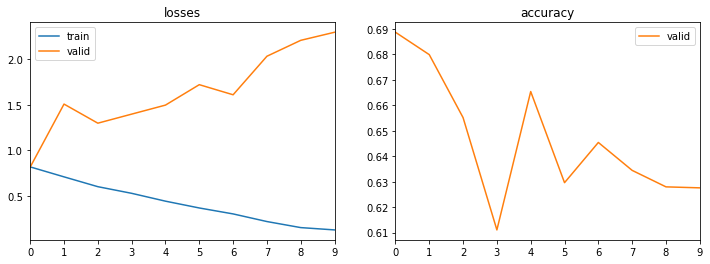

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 50, 'lr': 0.01, 'nf': 32, 'optimizer': <function Adam at 0x000002552D0DD438>, 'patience': 5, 'time_steps': 90}
InceptionTime                                                                                                          
 27%|████████████▎                                 | 8/30 [24:10<1:11:05, 193.87s/trial, best loss: 0.9088351130485535]

epoch,train_loss,valid_loss,accuracy,time
0,0.818536,0.877940,0.688239,00:11
1,0.701476,0.870719,0.679504,00:10
2,0.638789,1.112558,0.660103,00:10
3,0.604784,0.940971,0.663095,00:10
4,0.571555,1.221596,0.591670,00:10
5,0.529744,1.555776,0.513006,00:10
6,0.509198,1.451744,0.669659,00:10


No improvement since epoch 1: early stopping                                                                           
 27%|████████████▎                                 | 8/30 [25:28<1:11:05, 193.87s/trial, best loss: 0.9088351130485535]

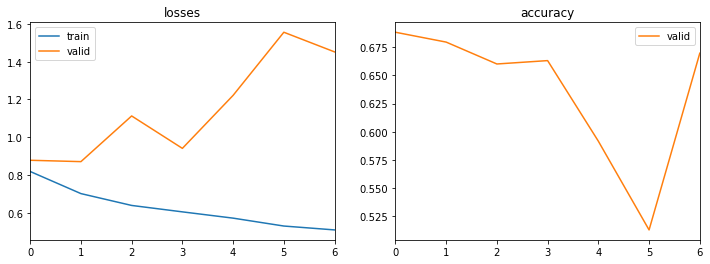

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 50, 'lr': 0.0001, 'nf': 64, 'optimizer': <function RMSProp at 0x000002552D0DD1F8>, 'patience': 10, 'time_steps': 60}
InceptionTime                                                                                                          
 30%|██████████████▍                                 | 9/30 [25:54<58:21, 166.76s/trial, best loss: 0.9088351130485535]

epoch,train_loss,valid_loss,accuracy,time
0,1.315743,1.308002,0.612326,00:18
1,1.066479,1.042270,0.658318,00:18
2,0.931939,0.924042,0.679600,00:18
3,0.857585,0.895902,0.678925,00:18
4,0.806743,0.871227,0.687322,00:19
5,0.762422,0.942984,0.656098,00:19
6,0.711416,0.967308,0.683413,00:19
7,0.664070,0.973337,0.646735,00:19
8,0.625066,0.994163,0.666956,00:19
9,0.577780,1.071168,0.660827,00:19


No improvement since epoch 4: early stopping                                                                           
 30%|██████████████▍                                 | 9/30 [30:42<58:21, 166.76s/trial, best loss: 0.9088351130485535]

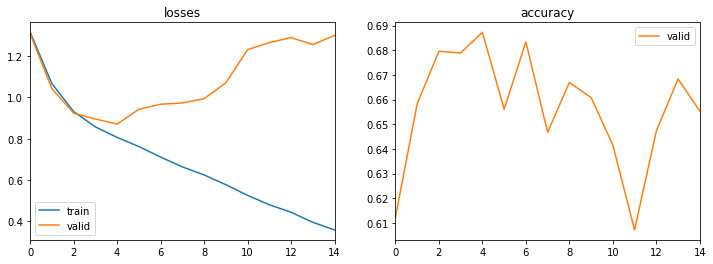

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 10, 'lr': 0.0001, 'nf': 16, 'optimizer': <function SGD at 0x000002552D0DD0D8>, 'patience': 10, 'time_steps': 90}
InceptionTime                                                                                                          
 33%|███████████████                              | 10/30 [31:09<1:10:21, 211.05s/trial, best loss: 0.9088351130485535]

epoch,train_loss,valid_loss,accuracy,time
0,1.698558,1.713817,0.341827,00:08
1,1.522783,1.519513,0.551904,00:08
2,1.344612,1.339278,0.643164,00:08
3,1.243781,1.248233,0.659379,00:08
4,1.199123,1.198139,0.662468,00:08
5,1.172146,1.173130,0.663337,00:08
6,1.147790,1.159088,0.663723,00:08
7,1.146593,1.151882,0.663675,00:08
8,1.142684,1.150045,0.663626,00:08
9,1.140480,1.150117,0.663626,00:08


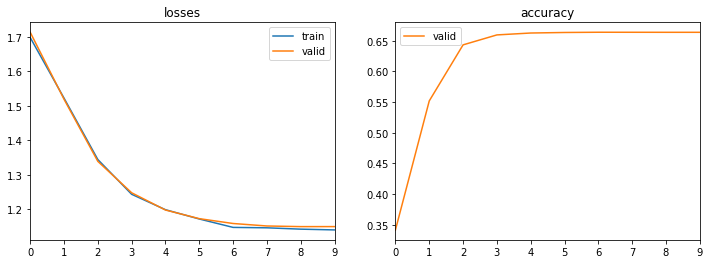

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'lr': 0.001, 'nf': 32, 'optimizer': <function RMSProp at 0x000002552D0DD1F8>, 'patience': 10, 'time_steps': 30}
InceptionTime                                                                                                          
 37%|█████████████████▏                             | 11/30 [33:01<57:28, 181.50s/trial, best loss: 0.9088351130485535]

epoch,train_loss,valid_loss,accuracy,time
0,0.925100,0.951810,0.669369,00:09
1,0.878807,0.995721,0.642730,00:09
2,0.823193,0.973923,0.676560,00:09
3,0.783169,1.073455,0.667487,00:09
4,0.730053,1.216436,0.664254,00:09
5,0.697769,1.361576,0.590898,00:09
6,0.657647,1.153033,0.644612,00:09
7,0.623828,1.205889,0.649052,00:09
8,0.602956,1.215819,0.657690,00:09
9,0.570602,1.461832,0.559432,00:09


No improvement since epoch 0: early stopping                                                                           
 37%|█████████████████▏                             | 11/30 [34:42<57:28, 181.50s/trial, best loss: 0.9088351130485535]

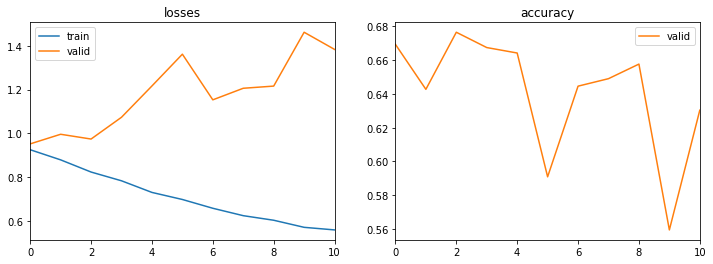

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 50, 'lr': 0.001, 'nf': 32, 'optimizer': <function RMSProp at 0x000002552D0DD1F8>, 'patience': 5, 'time_steps': 60}
InceptionTime                                                                                                          
 40%|██████████████████▊                            | 12/30 [35:08<49:31, 165.08s/trial, best loss: 0.9088351130485535]

epoch,train_loss,valid_loss,accuracy,time
0,0.895442,1.046533,0.628493,00:10
1,0.824063,0.916315,0.681289,00:10
2,0.761968,1.063413,0.597848,00:10
3,0.706731,1.067270,0.663868,00:10
4,0.660942,1.034489,0.664688,00:10
5,0.610861,1.350603,0.641571,00:10
6,0.569742,1.071007,0.674195,00:10


No improvement since epoch 1: early stopping                                                                           
 40%|██████████████████▊                            | 12/30 [36:20<49:31, 165.08s/trial, best loss: 0.9088351130485535]

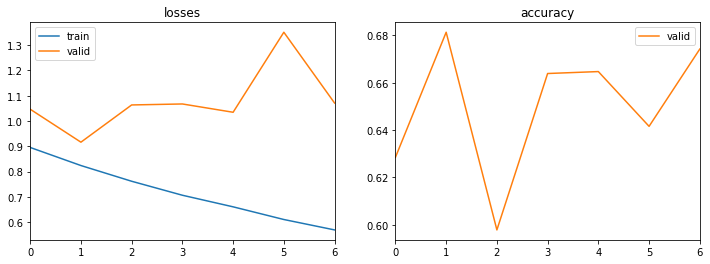

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'lr': 0.001, 'nf': 64, 'optimizer': <function Adam at 0x000002552D0DD438>, 'patience': 5, 'time_steps': 30}
InceptionTime                                                                                                          
 43%|████████████████████▎                          | 13/30 [36:46<41:07, 145.16s/trial, best loss: 0.9088351130485535]

epoch,train_loss,valid_loss,accuracy,time
0,0.908736,0.964882,0.668308,00:15
1,0.812245,0.984633,0.656966,00:15
2,0.735182,1.036918,0.651851,00:15
3,0.677559,1.169063,0.656001,00:15
4,0.633508,1.154270,0.636938,00:15
5,0.586170,1.152415,0.626659,00:15


No improvement since epoch 0: early stopping                                                                           
 43%|████████████████████▎                          | 13/30 [38:18<41:07, 145.16s/trial, best loss: 0.9088351130485535]

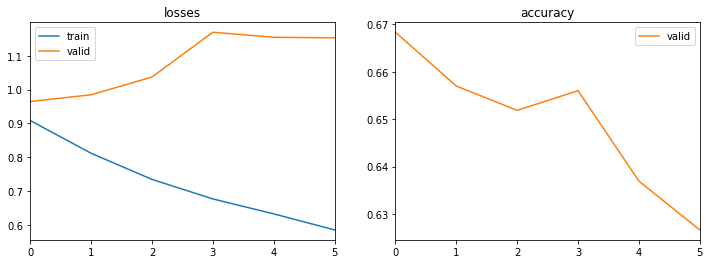

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 50, 'lr': 0.0001, 'nf': 16, 'optimizer': <function RMSProp at 0x000002552D0DD1F8>, 'patience': 10, 'time_steps': 30}
InceptionTime                                                                                                          
 47%|█████████████████████▉                         | 14/30 [38:44<36:31, 136.97s/trial, best loss: 0.9088351130485535]

epoch,train_loss,valid_loss,accuracy,time
0,1.716650,1.699497,0.326770,00:09
1,1.475924,1.488244,0.546981,00:09
2,1.255301,1.257604,0.611312,00:09
3,1.063190,1.048524,0.652526,00:09
4,0.963072,0.968158,0.665605,00:09
5,0.918183,0.944559,0.673134,00:09
6,0.898533,0.923130,0.677139,00:09
7,0.874759,0.957896,0.675981,00:09
8,0.851237,0.918508,0.683075,00:09
9,0.819811,0.938627,0.682400,00:09


No improvement since epoch 8: early stopping                                                                           
 47%|█████████████████████▉                         | 14/30 [41:39<36:31, 136.97s/trial, best loss: 0.9088351130485535]

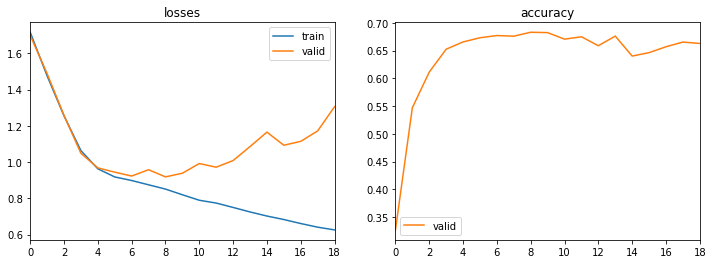

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 100, 'lr': 0.0001, 'nf': 16, 'optimizer': <function SGD at 0x000002552D0DD0D8>, 'patience': 10, 'time_steps': 60}
InceptionTime                                                                                                          
 50%|███████████████████████▌                       | 15/30 [42:05<38:59, 155.99s/trial, best loss: 0.9088351130485535]

epoch,train_loss,valid_loss,accuracy,time
0,1.955402,1.957254,0.049949,00:08
1,1.928391,1.932724,0.052073,00:08
2,1.903751,1.900521,0.055692,00:08
3,1.861622,1.854032,0.065393,00:08
4,1.814471,1.810458,0.094011,00:08
5,1.761504,1.753857,0.162106,00:08
6,1.696823,1.678337,0.293470,00:08
7,1.623121,1.607666,0.416293,00:08
8,1.546864,1.531496,0.525506,00:08
9,1.472151,1.455784,0.595242,00:08


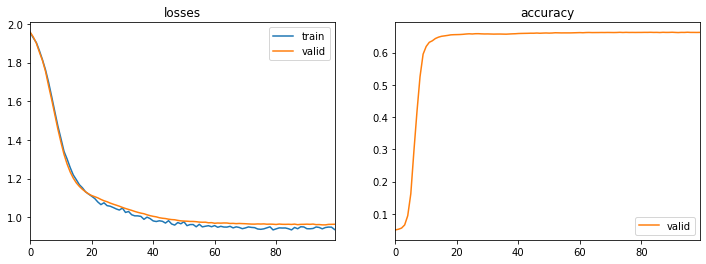

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 10, 'lr': 0.0001, 'nf': 32, 'optimizer': <function SGD at 0x000002552D0DD0D8>, 'patience': 5, 'time_steps': 60}
InceptionTime                                                                                                          
 53%|████████████████████████                     | 16/30 [56:27<1:25:49, 367.84s/trial, best loss: 0.9088351130485535]

epoch,train_loss,valid_loss,accuracy,time
0,1.747666,1.722110,0.123643,00:10
1,1.419244,1.378877,0.650596,00:10
2,1.214383,1.197370,0.662661,00:10
3,1.140599,1.137517,0.663337,00:10
4,1.106859,1.112955,0.662951,00:10
5,1.096935,1.099918,0.662227,00:10
6,1.079966,1.090653,0.661551,00:10
7,1.080476,1.087189,0.661117,00:10
8,1.075227,1.084015,0.661213,00:10
9,1.074933,1.084650,0.661020,00:10


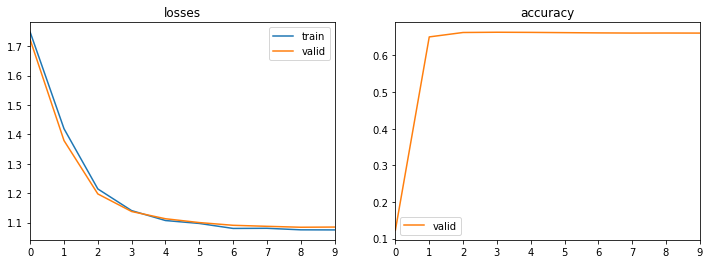

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 10, 'lr': 0.1, 'nf': 64, 'optimizer': <function RMSProp at 0x000002552D0DD1F8>, 'patience': 10, 'time_steps': 60}
InceptionTime                                                                                                          
 57%|█████████████████████████▌                   | 17/30 [58:40<1:04:10, 296.20s/trial, best loss: 0.9088351130485535]

epoch,train_loss,valid_loss,accuracy,time
0,0.975755,0.904923,0.676705,00:18
1,0.923953,0.929532,0.671396,00:18
2,0.830417,1.286335,0.622316,00:19
3,0.917569,0.979331,0.663481,00:19
4,0.769499,1.086744,0.676705,00:19
5,0.671576,1.227616,0.681386,00:19
6,0.594118,1.332987,0.666281,00:19
7,0.530525,1.473901,0.655422,00:19
8,0.481012,1.638305,0.655663,00:19
9,0.454095,1.662474,0.653974,00:19


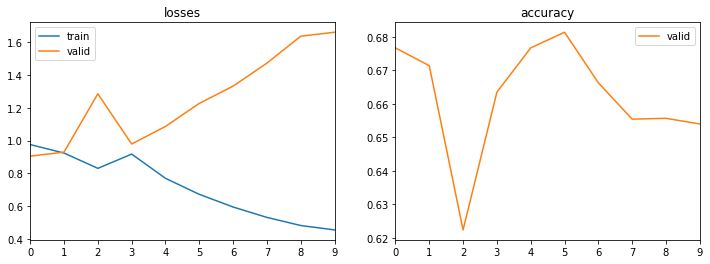

Trying params:                                                                                                         
{'batch_size': 512, 'epochs': 50, 'lr': 0.01, 'nf': 32, 'optimizer': <function SGD at 0x000002552D0DD0D8>, 'patience': 5, 'time_steps': 60}
InceptionTime                                                                                                          
 60%|███████████████████████████                  | 18/30 [1:02:24<54:57, 274.79s/trial, best loss: 0.9088351130485535]

epoch,train_loss,valid_loss,accuracy,time
0,1.256222,1.160168,0.662758,00:09
1,1.089201,1.072969,0.659958,00:08
2,1.007670,1.009181,0.657932,00:08
3,0.952580,0.978487,0.660586,00:08
4,0.921835,0.943701,0.666618,00:08
5,0.896523,0.929237,0.675498,00:08
6,0.868746,0.905083,0.684137,00:08
7,0.850167,0.885130,0.685199,00:08
8,0.821660,0.947617,0.673954,00:08
9,0.792238,0.930921,0.659621,00:08


No improvement since epoch 7: early stopping                                                                           
 60%|███████████████████████████                  | 18/30 [1:04:16<54:57, 274.79s/trial, best loss: 0.9088351130485535]

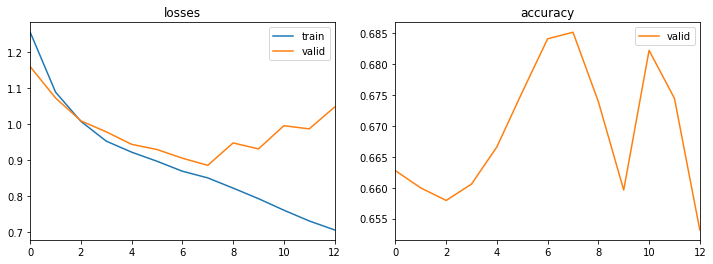

Trying params:                                                                                                         
{'batch_size': 256, 'epochs': 10, 'lr': 0.01, 'nf': 16, 'optimizer': <function Adam at 0x000002552D0DD438>, 'patience': 5, 'time_steps': 30}
InceptionTime                                                                                                          
 63%|████████████████████████████▌                | 19/30 [1:04:46<43:03, 234.91s/trial, best loss: 0.9088351130485535]

epoch,train_loss,valid_loss,accuracy,time
0,0.908654,0.922711,0.681772,00:10
1,0.853829,0.961356,0.670045,00:10
2,0.783006,1.123813,0.673568,00:10
3,0.719050,1.088658,0.652961,00:10
4,0.656792,1.136244,0.650306,00:10
5,0.605417,1.248405,0.655277,00:10


No improvement since epoch 0: early stopping                                                                           
 63%|████████████████████████████▌                | 19/30 [1:05:51<43:03, 234.91s/trial, best loss: 0.9088351130485535]

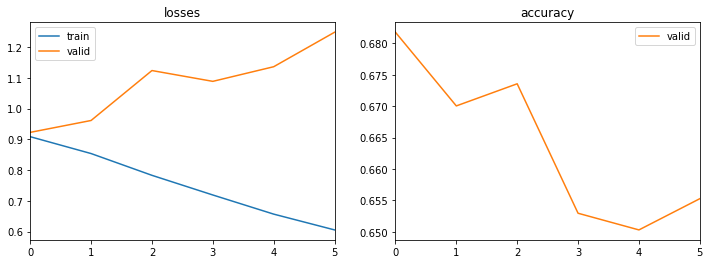

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'lr': 0.1, 'nf': 64, 'optimizer': <function SGD at 0x000002552D0DD0D8>, 'patience': 5, 'time_steps': 90}
InceptionTime                                                                                                          
 67%|██████████████████████████████               | 20/30 [1:06:20<32:09, 192.93s/trial, best loss: 0.9088351130485535]

epoch,train_loss,valid_loss,accuracy,time
0,1.025952,0.999748,0.657594,00:21
1,0.930958,0.967183,0.660345,00:22
2,0.888744,0.873117,0.680759,00:22
3,0.860465,0.967591,0.644757,00:23
4,0.839839,0.883165,0.676415,00:23
5,0.815292,0.935761,0.647749,00:24
6,0.794513,0.892403,0.683172,00:24
7,0.761195,1.071045,0.657739,00:24


No improvement since epoch 2: early stopping                                                                           
 67%|██████████████████████████████               | 20/30 [1:09:26<32:09, 192.93s/trial, best loss: 0.9088351130485535]

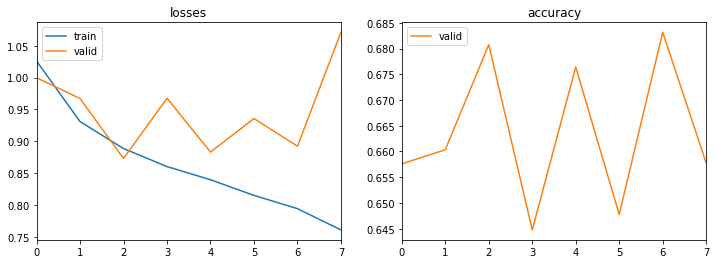

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'lr': 0.1, 'nf': 64, 'optimizer': <function SGD at 0x000002552D0DD0D8>, 'patience': 5, 'time_steps': 90}
InceptionTime                                                                                                          
 70%|███████████████████████████████▍             | 21/30 [1:09:55<29:54, 199.38s/trial, best loss: 0.9088351130485535]

epoch,train_loss,valid_loss,accuracy,time
0,1.017957,0.986724,0.656918,00:22
1,0.928985,0.929179,0.666618,00:23
2,0.884929,1.024886,0.633029,00:24
3,0.854463,0.954225,0.672747,00:23
4,0.837086,0.858984,0.691424,00:24
5,0.808467,0.979297,0.647604,00:24
6,0.781113,0.894668,0.662082,00:24
7,0.748494,0.950246,0.681193,00:24
8,0.726068,1.036756,0.656629,00:24
9,0.688898,1.237477,0.604121,00:24


No improvement since epoch 4: early stopping                                                                           
 70%|███████████████████████████████▍             | 21/30 [1:13:56<29:54, 199.38s/trial, best loss: 0.9088351130485535]

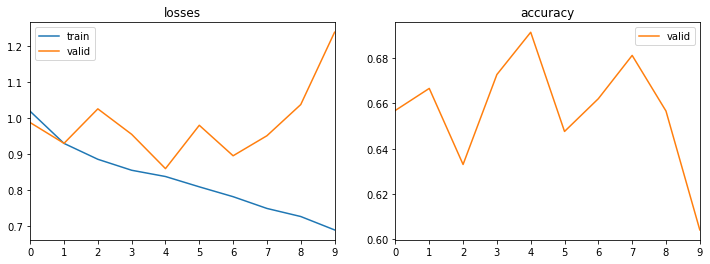

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'lr': 0.1, 'nf': 64, 'optimizer': <function SGD at 0x000002552D0DD0D8>, 'patience': 5, 'time_steps': 90}
InceptionTime                                                                                                          
 73%|█████████████████████████████████            | 22/30 [1:14:23<29:25, 220.75s/trial, best loss: 0.9088351130485535]

epoch,train_loss,valid_loss,accuracy,time
0,1.021961,0.984658,0.655905,00:22
1,0.927736,0.949032,0.661792,00:23
2,0.886297,1.039688,0.637759,00:24
3,0.856218,0.920339,0.669804,00:24
4,0.832021,0.903865,0.670286,00:24
5,0.808123,0.936823,0.665508,00:25
6,0.782969,1.037786,0.585879,00:25
7,0.754802,0.963603,0.641861,00:25
8,0.723847,0.915116,0.668887,00:25
9,0.703405,1.045232,0.631919,00:25


No improvement since epoch 4: early stopping                                                                           
 73%|█████████████████████████████████            | 22/30 [1:18:30<29:25, 220.75s/trial, best loss: 0.9088351130485535]

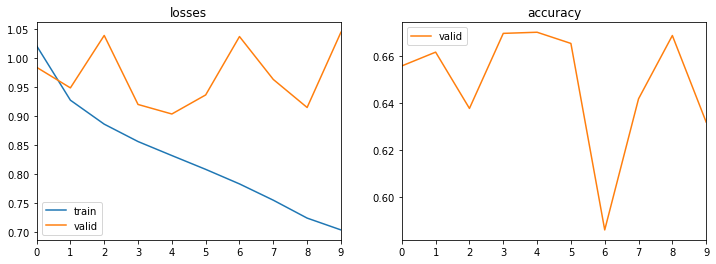

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'lr': 0.001, 'nf': 32, 'optimizer': <function SGD at 0x000002552D0DD0D8>, 'patience': 5, 'time_steps': 90}
InceptionTime                                                                                                          
 77%|██████████████████████████████████▌          | 23/30 [1:18:57<27:35, 236.54s/trial, best loss: 0.9088351130485535]

epoch,train_loss,valid_loss,accuracy,time
0,1.667430,1.608932,0.456300,00:10
1,1.602545,1.533845,0.616379,00:10
2,1.523228,1.451599,0.663723,00:10
3,1.438313,1.368244,0.664398,00:10
4,1.355368,1.289332,0.664350,00:11
5,1.281709,1.224379,0.664302,00:10
6,1.219463,1.175592,0.664302,00:11
7,1.172819,1.143611,0.664205,00:11
8,1.138154,1.120187,0.663771,00:11
9,1.108864,1.101777,0.663240,00:11


No improvement since epoch 51: early stopping                                                                          
 77%|██████████████████████████████████▌          | 23/30 [1:29:43<27:35, 236.54s/trial, best loss: 0.9088351130485535]

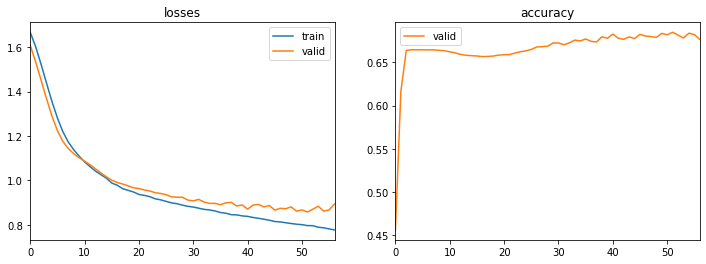

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'lr': 0.001, 'nf': 32, 'optimizer': <function SGD at 0x000002552D0DD0D8>, 'patience': 5, 'time_steps': 90}
InceptionTime                                                                                                          
 80%|████████████████████████████████████         | 24/30 [1:30:09<36:45, 367.58s/trial, best loss: 0.8934639692306519]

epoch,train_loss,valid_loss,accuracy,time
0,1.798916,1.753379,0.190483,00:09
1,1.711569,1.648756,0.297186,00:10
2,1.612035,1.541609,0.425896,00:10
3,1.503783,1.431665,0.584817,00:10
4,1.400789,1.331038,0.637035,00:11
5,1.310756,1.247841,0.650693,00:11
6,1.236575,1.188853,0.658414,00:11
7,1.185521,1.149204,0.661358,00:11
8,1.146019,1.120279,0.661261,00:11
9,1.116864,1.099284,0.660875,00:11


No improvement since epoch 61: early stopping                                                                          
 80%|████████████████████████████████████         | 24/30 [1:43:01<36:45, 367.58s/trial, best loss: 0.8934639692306519]

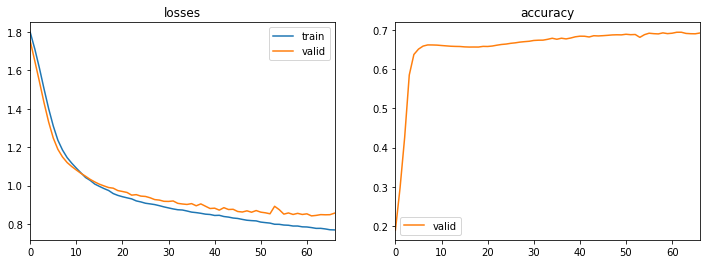

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'lr': 0.001, 'nf': 32, 'optimizer': <function SGD at 0x000002552D0DD0D8>, 'patience': 5, 'time_steps': 90}
InceptionTime                                                                                                          
 83%|█████████████████████████████████████▌       | 25/30 [1:43:27<41:23, 496.61s/trial, best loss: 0.8563053011894226]

epoch,train_loss,valid_loss,accuracy,time
0,1.769858,1.730031,0.248588,00:10
1,1.695880,1.644852,0.464891,00:10
2,1.611158,1.552627,0.628010,00:11
3,1.521028,1.455102,0.652961,00:11
4,1.428377,1.362441,0.659476,00:11
5,1.344660,1.284636,0.663144,00:11
6,1.272573,1.226509,0.663868,00:11
7,1.221146,1.182497,0.664205,00:11
8,1.175489,1.150940,0.664205,00:11
9,1.142839,1.125798,0.664109,00:11


No improvement since epoch 59: early stopping                                                                          
 83%|█████████████████████████████████████▌       | 25/30 [1:55:59<41:23, 496.61s/trial, best loss: 0.8563053011894226]

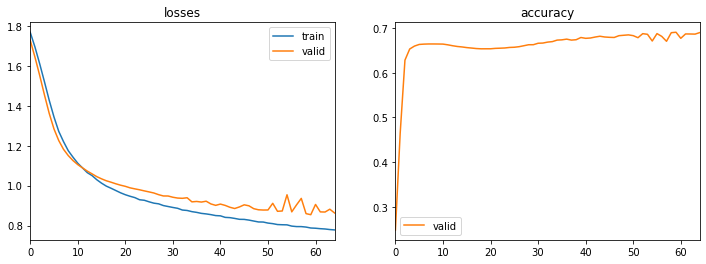

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'lr': 0.001, 'nf': 32, 'optimizer': <function SGD at 0x000002552D0DD0D8>, 'patience': 5, 'time_steps': 90}
InceptionTime                                                                                                          
 87%|███████████████████████████████████████      | 26/30 [1:56:26<38:44, 581.13s/trial, best loss: 0.8563053011894226]

epoch,train_loss,valid_loss,accuracy,time
0,2.067519,2.094685,0.068433,00:10
1,1.968811,1.978458,0.069109,00:10
2,1.846548,1.837177,0.112012,00:10
3,1.705143,1.682217,0.468221,00:11
4,1.554295,1.522962,0.603591,00:11
5,1.413375,1.386514,0.636890,00:11
6,1.301870,1.283076,0.657546,00:11
7,1.218499,1.214759,0.663964,00:11
8,1.165840,1.170125,0.664254,00:11
9,1.127019,1.140344,0.664205,00:11


No improvement since epoch 43: early stopping                                                                          
 87%|███████████████████████████████████████      | 26/30 [2:05:49<38:44, 581.13s/trial, best loss: 0.8563053011894226]

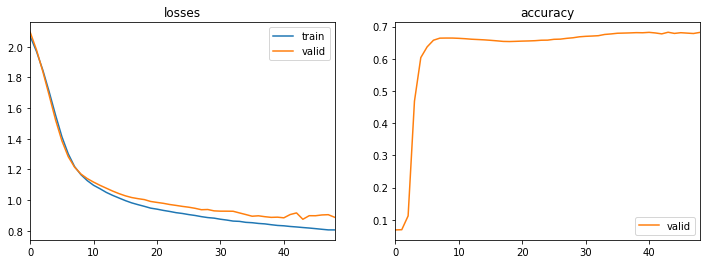

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'lr': 0.001, 'nf': 32, 'optimizer': <function SGD at 0x000002552D0DD0D8>, 'patience': 5, 'time_steps': 90}
InceptionTime                                                                                                          
 90%|████████████████████████████████████████▌    | 27/30 [2:06:16<29:11, 583.83s/trial, best loss: 0.8563053011894226]

epoch,train_loss,valid_loss,accuracy,time
0,1.437081,1.402239,0.634381,00:09
1,1.399982,1.361773,0.642826,00:10
2,1.359946,1.320827,0.649776,00:10
3,1.316362,1.275199,0.655181,00:11
4,1.270734,1.232967,0.657835,00:11
5,1.224784,1.196307,0.659476,00:11
6,1.187977,1.165190,0.660152,00:11
7,1.156305,1.140823,0.660345,00:11
8,1.129277,1.121662,0.660248,00:11
9,1.104119,1.104767,0.660103,00:11


No improvement since epoch 52: early stopping                                                                          
 90%|████████████████████████████████████████▌    | 27/30 [2:17:25<29:11, 583.83s/trial, best loss: 0.8563053011894226]

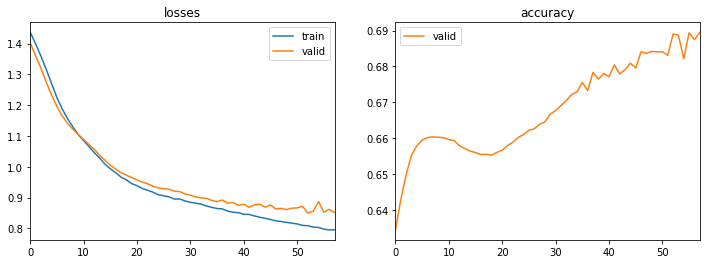

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'lr': 0.001, 'nf': 32, 'optimizer': <function SGD at 0x000002552D0DD0D8>, 'patience': 5, 'time_steps': 90}
InceptionTime                                                                                                          
 93%|██████████████████████████████████████████   | 28/30 [2:17:52<20:35, 617.51s/trial, best loss: 0.8511567115783691]

epoch,train_loss,valid_loss,accuracy,time
0,1.764579,1.702929,0.291540,00:09
1,1.693818,1.623281,0.384200,00:10
2,1.610724,1.532246,0.521693,00:10
3,1.518126,1.438192,0.628252,00:11
4,1.422047,1.345989,0.648762,00:11
5,1.331120,1.266464,0.658414,00:11
6,1.254679,1.204126,0.662854,00:11
7,1.197361,1.162002,0.663337,00:11
8,1.157641,1.131066,0.663868,00:11
9,1.121282,1.105769,0.663771,00:11


No improvement since epoch 47: early stopping                                                                          
 93%|██████████████████████████████████████████   | 28/30 [2:28:03<20:35, 617.51s/trial, best loss: 0.8511567115783691]

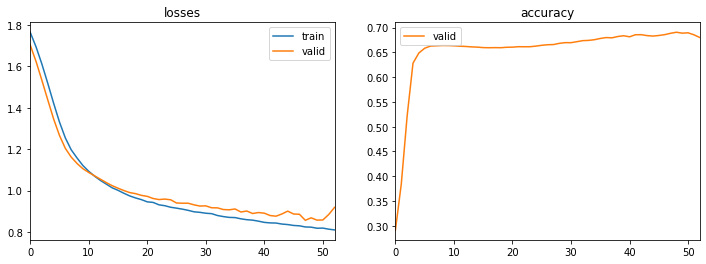

Trying params:                                                                                                         
{'batch_size': 1024, 'epochs': 100, 'lr': 0.001, 'nf': 32, 'optimizer': <function SGD at 0x000002552D0DD0D8>, 'patience': 5, 'time_steps': 90}
InceptionTime                                                                                                          
 97%|███████████████████████████████████████████▌ | 29/30 [2:28:29<10:23, 623.46s/trial, best loss: 0.8511567115783691]

epoch,train_loss,valid_loss,accuracy,time
0,1.673218,1.653337,0.400174,00:09
1,1.606477,1.574186,0.501182,00:10
2,1.528063,1.486263,0.598668,00:10
3,1.442268,1.394037,0.633801,00:11
4,1.356780,1.308040,0.653781,00:11
5,1.278951,1.233870,0.661068,00:11
6,1.211650,1.178470,0.663819,00:11
7,1.162372,1.139049,0.664495,00:11
8,1.127189,1.111921,0.664398,00:11
9,1.096129,1.090753,0.663530,00:11


No improvement since epoch 50: early stopping                                                                          
 97%|███████████████████████████████████████████▌ | 29/30 [2:39:16<10:23, 623.46s/trial, best loss: 0.8511567115783691]

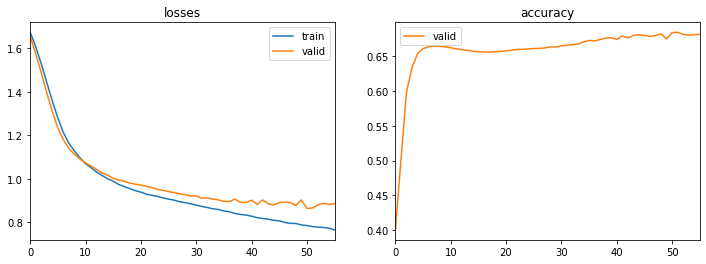

100%|█████████████████████████████████████████████| 30/30 [2:39:16<00:00, 318.54s/trial, best loss: 0.8511567115783691]


In [34]:
trials = Trials()
best = fmin(create_model_hypopt,
    space=search_space,
    algo=tpe.suggest,
    max_evals=30,  # test trials
    trials=trials)

In [35]:
print(best)

{'bs': 2, 'epochs': 2, 'lr': 2, 'nf': 1, 'optimizer': 1, 'patience': 0, 'ts': 2}


In [36]:
from hyperopt import space_eval

In [37]:
print("Best parameters:")
print(space_eval(search_space, best))

Best parameters:
{'batch_size': 1024, 'epochs': 100, 'lr': 0.001, 'nf': 32, 'optimizer': <function SGD at 0x000002552D0DD0D8>, 'patience': 5, 'time_steps': 90}


In [38]:
best_parameters = space_eval(search_space, best)

In [39]:
def build_model(params):
    # clear memory 
    gc.collect()
    print("Trying params:",params)
    batch_size = params["batch_size"]
    time_steps = params["time_steps"]
    
    # Create data loader
    tfms  = [None, [Categorize()]]
    dsets = TSDatasets(X[:, :, -time_steps:], y, tfms=tfms, splits=splits, inplace=True)
    # set num_workers for memory bottleneck
    dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[batch_size, batch_size], num_workers=0)
    
    # Create model
    arch = InceptionTime
    k = {
        'nf': params['nf']
    }
    model = create_model(arch, dls=dls, **k)
    print(model.__class__.__name__)
    
    # Training the model
    learn = Learner(dls, model, metrics=accuracy, opt_func=params['optimizer'])
    start = time.time()
    learn.fit_one_cycle(params['epochs'], lr_max=params['lr'],
                        cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0, patience=params['patience']))
    learn.plot_metrics()
    elapsed = time.time() - start
    
    # delete tmp variables
    del dls
    del model
    return learn

Trying params: {'batch_size': 1024, 'epochs': 100, 'lr': 0.001, 'nf': 32, 'optimizer': <function SGD at 0x000002552D0DD0D8>, 'patience': 5, 'time_steps': 90}
InceptionTime


epoch,train_loss,valid_loss,accuracy,time
0,1.753314,1.747454,0.296076,00:09
1,1.682658,1.661465,0.363641,00:10
2,1.597463,1.565667,0.543314,00:10
3,1.502062,1.462031,0.652382,00:11
4,1.406448,1.362205,0.663095,00:11
5,1.318487,1.280574,0.663819,00:11
6,1.253323,1.218005,0.664109,00:11
7,1.198763,1.174678,0.664350,00:11
8,1.160536,1.144502,0.664254,00:11
9,1.132244,1.122094,0.664012,00:11


No improvement since epoch 42: early stopping


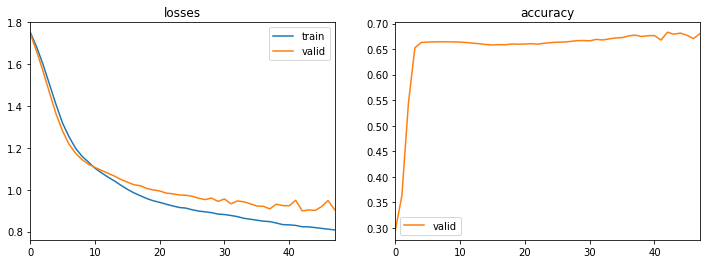

In [40]:
learn = build_model(best_parameters)

In [41]:
dls = learn.dls
valid_dl = dls.valid

In [42]:
time_steps = best_parameters["time_steps"]
X_test_tmp = X_test[:, :, -time_steps:]

In [43]:
test_ds = valid_dl.dataset.add_test(X_test_tmp, y_test)  # use the test data
test_dl = valid_dl.new(test_ds)
print(test_dl.n)

102430


In [44]:
test_probas, test_targets, test_preds = learn.get_preds(dl=test_dl, with_decoded=True, save_preds=None, save_targs=None)
test_probas, test_targets, test_preds

(tensor([[6.1382e-01, 2.1734e-01, 9.6955e-02, 4.9329e-02, 1.6512e-02, 6.0380e-03],
         [8.8481e-01, 7.8274e-02, 2.3464e-02, 4.3730e-03, 5.3680e-03, 3.7098e-03],
         [9.7071e-01, 2.0895e-02, 6.4142e-03, 1.4385e-03, 3.9351e-04, 1.5166e-04],
         ...,
         [9.6272e-01, 2.8945e-02, 5.2799e-03, 1.3870e-03, 8.4730e-04, 8.2227e-04],
         [9.9588e-01, 3.4033e-03, 4.9473e-04, 1.1016e-04, 5.8667e-05, 5.5393e-05],
         [8.6270e-01, 8.6117e-02, 3.0707e-02, 1.0543e-02, 5.5648e-03, 4.3690e-03]]),
 TensorCategory([1, 0, 0,  ..., 0, 0, 0], dtype=torch.int32),
 tensor([0, 0, 0,  ..., 0, 0, 0]))

In [45]:
print(f'accuracy: {skm.accuracy_score(test_targets, test_preds):10.6f}')
print(f'f1 score: {skm.f1_score(test_targets, test_preds, average="weighted"):10.6f}')

accuracy:   0.729689
f1 score:   0.693582


Save the true and predicted results:

In [46]:
y_test_true = test_targets.numpy()
y_test_pred = test_preds.numpy()

In [47]:
np.save('y_true_InceptionTime', y_test_true)
np.save('y_pred_InceptionTime', y_test_pred)